In [100]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as sa
import scipy.linalg as la

In [101]:
# Data cleaning
df = pd.read_csv("Cleaned Datasets/US_Full_Quarterly.csv")
df["Log GDP"] = np.log(df["GDP"])
df['Diff Log GDP'] = df['Log GDP'] - df['Log GDP'].shift(1)
df["Log Inv"] = np.log(df["Inv"])
df["Diff Log Inv"] = df["Log Inv"] - df["Log Inv"].shift(1)
df["Log Dependency"] = np.log(df["Dependency"])
for i in range(1,4):
    df["Log Dependency"]+= np.log(df["Dependency"].shift(i))
df["Log Dependency"] /= 4

df["Diff Log Dependency"] = df["Log Dependency"] - df["Log Dependency"].shift(4)
df.set_index("DATE", drop=True, inplace=True)
df.dropna(inplace=True)
df = df[df.index <= "2017"]
df

,GDP,Inv,Exp,Imp,Gov,Cons,NXP,Fertility,Unemployment,Life_exp,...,recession_1990,recession_2001,recession_2008,recession_2020,Log GDP,Diff Log GDP,Log Inv,Diff Log Inv,Log Dependency,Diff Log Dependency
DATE,,,,,,,,,,,,,,,,,,,,,
1961-10-01,580.612,92.931,28.442,23.870,102.076,346.5,4.572,3.6200,6.5,70.270732,...,0,0,0,0,6.364083,0.022553,4.531857,0.021910,2.745684,0.011593
1962-01-01,594.013,98.074,28.325,24.314,105.952,353.2,4.011,3.4610,5.8,70.119512,...,0,0,0,0,6.386901,0.022818,4.585722,0.053865,2.747014,0.010024
1962-04-01,600.366,96.706,29.662,24.884,107.795,359.0,4.778,3.4610,5.6,70.119512,...,0,0,0,0,6.397539,0.010638,4.571675,-0.014047,2.748343,0.008456
1962-07-01,609.027,98.160,29.593,25.111,109.320,361.4,4.482,3.4610,5.4,70.119512,...,0,0,0,0,6.411863,0.014323,4.586599,0.014923,2.749673,0.006888
1962-10-01,612.280,94.968,28.683,25.550,111.161,366.5,3.133,3.4610,5.4,70.119512,...,0,0,0,0,6.417190,0.005327,4.553540,-0.033059,2.751003,0.005319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-01,18435.137,3276.879,2222.279,2745.517,4050.403,12394.9,-523.238,1.8435,5.0,78.690244,...,1,1,1,0,9.822014,0.001819,8.094647,-0.008139,3.072047,0.014498
2016-01-01,18525.933,3244.317,2181.957,2693.639,4084.292,12478.0,-511.682,1.8205,4.8,78.539024,...,1,1,1,0,9.826927,0.004913,8.084660,-0.009987,3.078824,0.017650
2016-04-01,18711.702,3246.381,2221.936,2711.306,4101.647,12611.5,-489.370,1.8205,5.1,78.539024,...,1,1,1,0,9.836904,0.009978,8.085296,0.000636,3.085601,0.020803


In [102]:
# For now, assume the dimension of the state space is 3
d = 3
data = df[["Diff Log GDP", "Diff Log Dependency", "Log Inv"]]
zMatrix = data.to_numpy()

In [103]:
def LogLikelihood(X):
    # Unpack the values
    dim_x = 3
    dim_z = 3

    dimF = dim_x**2
    dimH = dim_x * dim_z
    dimQ = dim_x**2
    dimR = dim_z**2
    dimP = dim_x**2

    F, H = X[:dimF].reshape(dim_x, dim_x), X[dimF:dimF+dimH].reshape(dim_x, dim_z)
    Q, R = X[dimF+dimH:dimF+dimH+dimQ].reshape(dim_x, dim_x), X[dimF+dimH+dimQ: dimF+dimH+dimQ+dimR].reshape(dim_z, dim_z)
    x0, P0 = X[dimF+dimH+dimQ+dimR: dimF+dimH+dimQ+dimR+dim_x], X[dimF+dimH+dimQ+dimR+dim_x: dimF+dimH+dimQ+dimR+dim_x+dimP].reshape(dim_x, dim_x)
    u = X[dimF+dimH+dimQ+dimR+dim_x+dimP:]
    xhat = x0.copy()
    Phat = P0.copy()
    logLikelis = []
    # Calculate the log-likelihood for each point.
    for i in range(zMatrix.shape[0]):
        # Predict the x value
        xhat = F@xhat
        # Predict the P value
        #Phat = F@Phat@(F.T) + Q # NOTE: I removed this to get it to work.
        mean = H@xhat + u
        cov = H@Phat@(H.T) + R
        logLikeli = np.log(sa.multivariate_normal.pdf(zMatrix[i,:], mean=mean, cov=cov, allow_singular=True))
        logLikelis.append(logLikeli)

    return -1*np.sum(logLikelis)

In [104]:
# Initialize Parameters
F = np.random.normal(size=(3,3)).ravel()
H = np.random.normal(size=(3,3)).ravel()
Q = np.eye(3).ravel()*.1
R = np.eye(3).ravel()*.1
x0 = np.ones(3).ravel()*1
P0 = np.eye(3).ravel()*10
u = x0.copy()

X = np.hstack((F, H, Q, R, x0, P0, u))

# Minimize and unpack values
X = minimize(LogLikelihood, X, method="bfgs", tol=1e-3).x
dim_x = 3
dim_z = 3

dimF = dim_x**2
dimH = dim_x * dim_z
dimQ = dim_x**2
dimR = dim_z**2
dimP = dim_x**2

F, H = X[:dimF].reshape(dim_x, dim_x), X[dimF:dimF+dimH].reshape(dim_x, dim_z)
Q, R = X[dimF+dimH:dimF+dimH+dimQ].reshape(dim_x, dim_x), X[dimF+dimH+dimQ: dimF+dimH+dimQ+dimR].reshape(dim_z, dim_z)
x0, P0 = X[dimF+dimH+dimQ+dimR: dimF+dimH+dimQ+dimR+dim_x], X[dimF+dimH+dimQ+dimR+dim_x: dimF+dimH+dimQ+dimR+dim_x+dimP].reshape(dim_x, dim_x)
u = X[dimF+dimH+dimQ+dimR+dim_x+dimP:]

/var/folders/vj/8t2xdhb577n2gr_0n_gppv480000gn/T/ipykernel_66222/4274844549.py:27: RuntimeWarning: divide by zero encountered in log
  logLikeli = np.log(sa.multivariate_normal.pdf(zMatrix[i,:], mean=mean, cov=cov, allow_singular=True))
/usr/local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [105]:
def filter(f,zs):
    n = np.size(zs,0)
    # initialize
    xhat = np.zeros((n,f.dim_x,1))
    Ps = np.zeros((n,f.dim_x,f.dim_x))
    z_filtered = np.zeros((n,f.dim_z))
    for i,z in enumerate(zs):
        f.predict()
        f.update(z)
        xhat[i] = f.x.copy()
        Ps[i] = f.P.copy()
        z_filtered[i] = (f.H)@(xhat[i].reshape(f.dim_x,))
        
    return xhat, Ps, z_filtered

def predict(f, zs, stepsForward):
    xhat, Ps, z_filtered = filter(f, zs)
    xhat_predict = np.zeros((stepsForward, f.dim_x, 1))
    Ps_predict = np.zeros((stepsForward, f.dim_x, f.dim_x))
    z_predicts = np.zeros((stepsForward, f.dim_z))

    for i in range(stepsForward):
        f.predict()
        xhat_predict[i] = f.x.copy()
        Ps[i] = f.P.copy()
        z_predicts[i] = (f.H)@(xhat_predict[i].reshape(f.dim_x,))
    
    return np.vstack((xhat, xhat_predict)), 0, np.vstack((z_filtered, z_predicts))

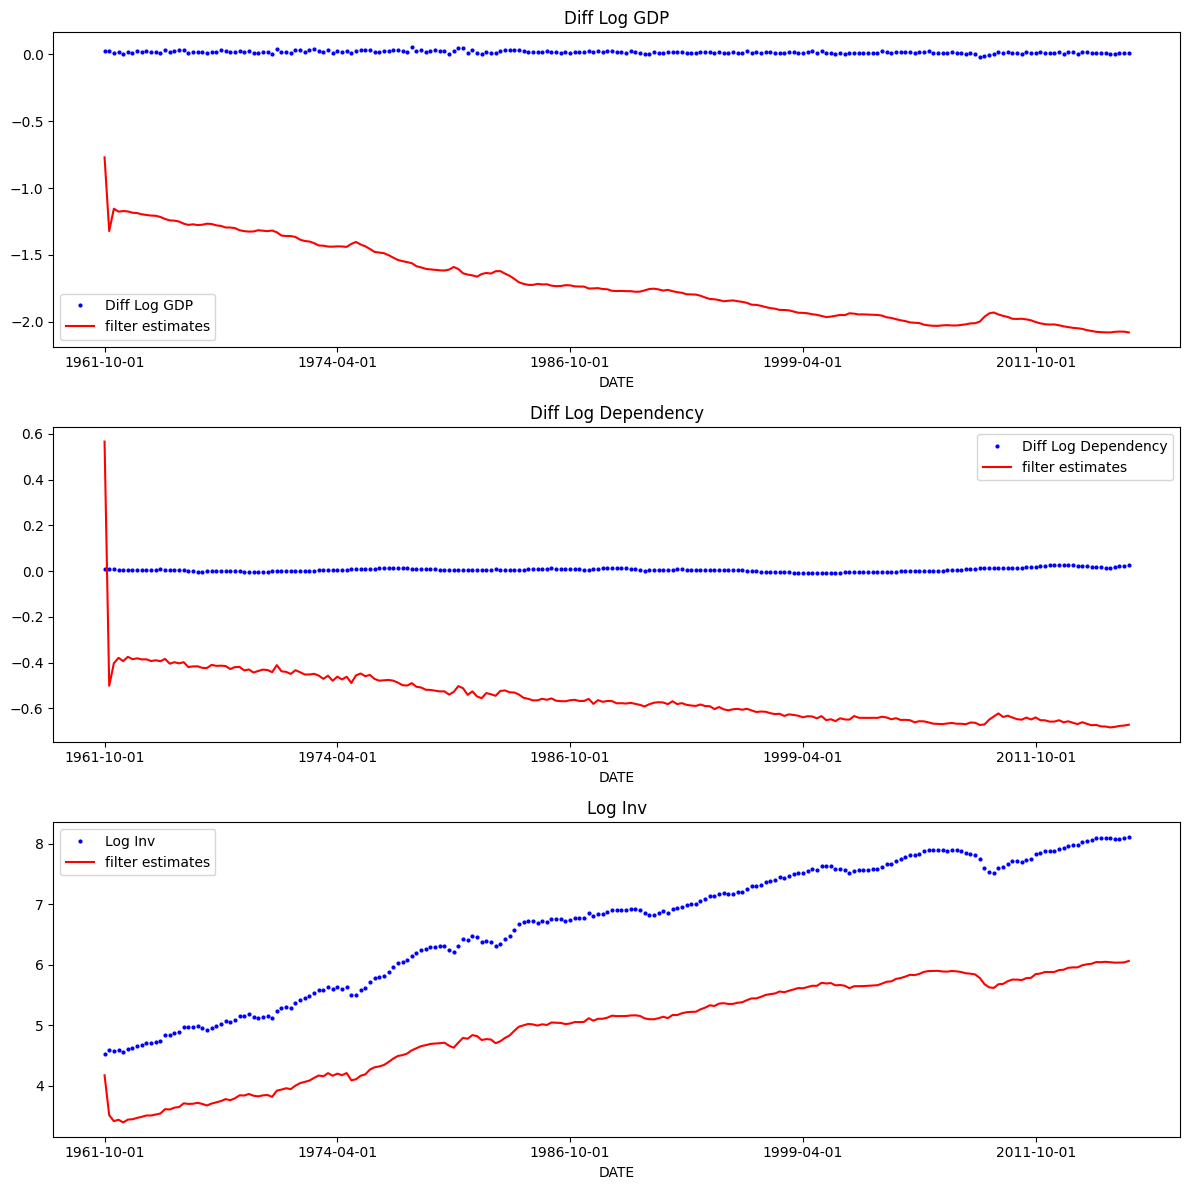

In [106]:
def KalmanFilterTrainAndGraph(df, F, H, Q, R, x0, u, y="GDP", stepsForward=0):
    # Format the data
    data = df.copy()
    var1 = 'Diff Log Dependency'
    var2 = 'Log Inv'
    data = data[[y, var1, var2]]

    # Train the model, calculate the optimal dimension and parameters

    f = KalmanFilter(dim_x=d, dim_z=len(data.columns))
    f.x = x0.reshape(-1,1).copy()
    f.F = F.copy()
    f.H = H.copy()
    f.Q = Q.copy()
    f.R = R.copy()
    f.B = u.copy()

    xhat, Ps, z_predicts = predict(f, zMatrix, stepsForward)

    # Plot the results
    fig, axs = plt.subplots(3,1,figsize=(12,12))

    data[[y]].plot(ax=axs[0], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    axs[0].plot(np.arange(z_predicts[:,0].size), z_predicts[:,0], label='filter estimates', color="r")
    axs[0].set_title(y)
    axs[0].legend()

    data[[var1]].plot(ax=axs[1], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    axs[1].plot(np.arange(z_predicts[:,1].size), z_predicts[:,1], label='filter estimates', color="r")
    axs[1].set_title(var1)
    axs[1].legend()

    data[[var2]].plot(ax=axs[2], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    axs[2].plot(np.arange(z_predicts[:,2].size), z_predicts[:,2], label='filter estimates', color="r")
    axs[2].set_title(var2)
    axs[2].legend()

    plt.legend()
    plt.tight_layout()

    return None

KalmanFilterTrainAndGraph(df, y="Diff Log GDP", F=F, H=H, Q=Q, R=R, x0=x0, u=u)